In [74]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})



In [ ]:
# Initialize Lattice
L = 1   
dx = 0.001 #mm resolution
x = np.arange(0, L, dx) # range [0, 5]
y = -x # range [-5, 0] (depth)
N = len(x)
lattice = np.zeros((N, N))


#Stratified initial lattice

top = np.zeros(int(N*0.1), N)
bottom = top

middle middle middle middle middle 



# Assign Solid Pixels Randomly represented by a 1 in matrix

# Number of solid pixels
perm_percent = 0.8
num_solid = int(perm_percent*N*N)


# Location of solid pixels
lattice = np.zeros(N*N, dtype=int)
lattice[:num_solid] = 1

np.random.shuffle(lattice)

lattice = lattice.reshape((len(x), len(x)))

plt.imshow(lattice, cmap="Greys", interpolation='none')
plt.title("Initial Lattice of Solid and Liquid Pixels")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.yticks([0,  200, 400, 600, 800], [0, -200, -400, -600, -800])

plt.show()




TypeError: expected a sequence of integers or a single integer, got '100.0'

(1000000, 2)


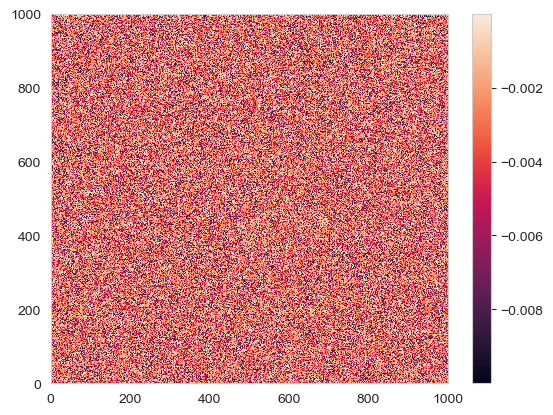

In [76]:
# Assign velocity vectors at each pixel
angle = np.random.uniform(np.pi, 2 * np.pi, size=(N* N , 2)) #generate angle in lower half plane (from pi to 2 pi)
direction = np.array([np.cos(angle[:,0]), np.sin(angle[:,1])]) # decompose into x and y components
direction= np.transpose(direction)
print(direction.shape)
magnitude = np.random.uniform(1, 10, size=(N*N)) * 10**-3 # randomly choose magnitude between 1 and 10 mm/s

#scale unit vectors
x_comp = magnitude*direction[:, 0]
x_comp=x_comp.reshape(N,N)

y_comp = magnitude*direction[:, 1]
y_comp=y_comp.reshape(N,N)
magnitude=magnitude.reshape(N,N)

velocities=np.array([x_comp, y_comp])


plt.figure()
plt.pcolor(y_comp)
plt.colorbar()







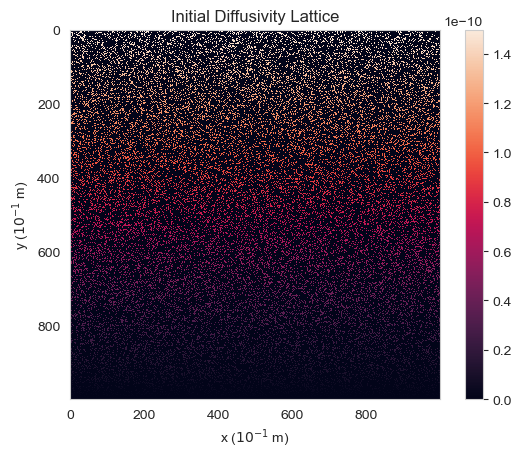

In [77]:

# Constants
kappa_d = 1.5 * 10 ** -7 # m^2 s^-1 water thermal diffusivity

# Calculate D0 at Each Pixel
D_0_vec = x * kappa_d * dx
D_0_vec = np.flip(D_0_vec)

D_0 = np.repeat(D_0_vec[np.newaxis,...], N, axis=0)
D_0 = D_0.transpose()
D_0[lattice > 0] = 0



plt.imshow(D_0, interpolation='none')
plt.title("Initial Diffusivity Lattice")
#plt.xticks([0, 100, 150, 200])
plt.xlabel("x ($10^{-1} $ m)")
#plt.yticks([0,  10, 20, 30], [0, -10, -20, -30])
plt.ylabel("y ($10^{-1} $ m)")
plt.colorbar()





In [78]:
# Random Walk

def computeProbability(D_i, D_j, v_j, i, j, e_ij):
    #D_i is diffusivity at current location
    #D_j is diffusivity at new location
    #v_ij is velocity at pixel j (need to calculate direction of flow at pixel j in direction of i)
    #i is position of pixel i
    #j is position of pixel j
    #e_ij points from j -> i

    if lattice[j[0], j[1]] == 1:
        b = 0
    else:
        v_ij = v_j @ e_ij  # flow at pixel j in direction of i
        D_eij = (D_i*D_j)**0.5 #geometric mean of diffusivity at i and j
        b = D_eij + (np.linalg.norm(v_j) * 0.5 * (v_ij /  np.linalg.norm(v_ij) + 1)) # compute probability

    return b

i = 0
j = int(N/2)
position = np.array([i, j]) # start walk at center top of snow
path = np.zeros((10000, 2))
probabilities = np.zeros((10000, 3))
moves = [''] * 10000


keep_going = True
k=0
while(keep_going==True):
    left = lattice[i,j-1]
    right = lattice[i, j+1]
    down = lattice[i+1, j]
    states = np.array([left, right ,down])

    # check if current position is surrounded by solid pixels
    if(states.all()==1):
        print("Walk terminated after ", k, " steps")
        break

    #compute probabilities 
    b_left = computeProbability(D_0[i, j], D_0[i, j-1], velocities[:, i, j-1], [i, j], [i, j-1], [1,0]) 
    b_right = computeProbability(D_0[i, j], D_0[i, j+1], velocities[:, i, j+1], [i, j], [i, j+1], [-1,0]) 
    b_down = computeProbability(D_0[i, j], D_0[i+1, j], velocities[:, i+1, j], [i, j], [i+1, j], [0,1])

    #Prevent the walk from moving backwards
    if(moves[k-1] == 'L' ):
        b_right = 0
    elif(moves[k-1] == 'R'):
        b_left = 0

    

    b_sum = b_left + b_right + b_down
    if (b_sum == 0):
        print(b_left, b_right, b_down)
        print("Walk terminated")
        break

    P_left = b_left / b_sum
    P_right = b_right / b_sum
    P_down = b_down / b_sum

    probs = np.array([P_left, P_right, P_down])
    
    probabilities[k, 0], probabilities[k, 1], probabilities[k, 2] = P_left, P_right, P_down

    #sample the distrubution
    move = np.random.choice(["L", "R", "D"], 1, p=probs)
    moves[k] = move[0]
    
    # update the position
    if (move == "L"):
        j = j-1
    elif (move == "R"):
        j = j+1
    elif (move == "D"):
        i = i+1
    
    k=k+1
    path[k, 0], path[k, 1] = i, j #update path history

    # check if we are at a boundary. if so then terminate walk
    if (j == 0 or j == N-1 or i == N-1):
        print("Walk terminated after ", k, " steps")
        break
        

    

    






0 0.0 0
Walk terminated


[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[1 1 1 1 0 1]
 [0 1 1 1 1 1]]
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''